In [654]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

np.random.seed(555)


In [655]:
def draw_path(path, ax, c='black'):
    for i in range(1, path.size):
        ax.plot(path[i-1:i+1, 0], path[i-1:i+1, 1], '.-', color=c)


# Generating Population

- `generate_population(n)` generates population of size `n` where their locations are randomized in [0, 1)


<Axes: xlabel='x', ylabel='y'>

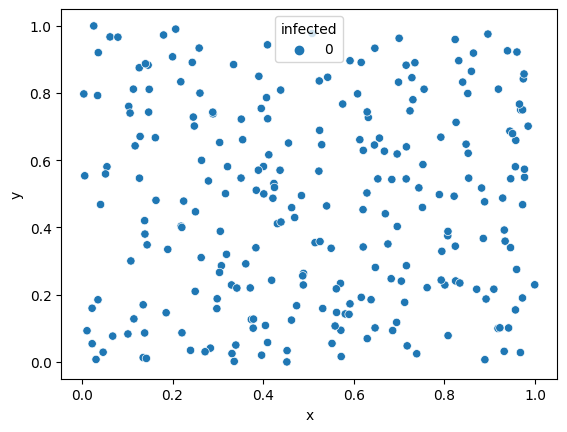

In [656]:
def generate_population(n=250):
    locations = [{"x": np.random.random(), "y": np.random.random(), "infected": 0}
                 for _ in range(n)]
    return pd.DataFrame(locations)


pop = generate_population()
sns.scatterplot(pop, x="x", y="y", hue="infected")


# Generating Path

- `generate_path(points)` generates a _path_ that are connected by a straight line
  - `point` can be changed to increase the number of direction changes
- `all_distances(path)` computes the distance between every two adjacent points in `path` and returns a list of it
- `total_distance(path)` computes the total distance of `path`


5.069478359213119


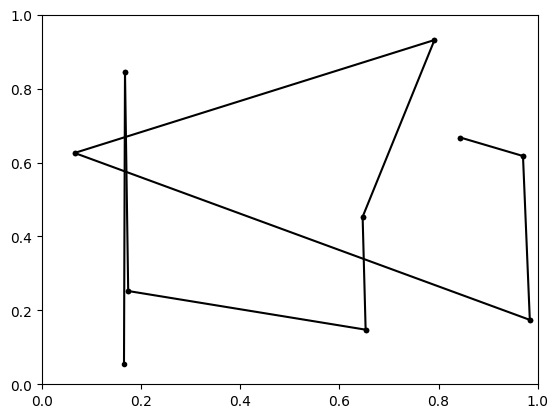

In [657]:
def generate_path(points=10):
    directions = np.random.random(size=(points, 2))
    return directions


def all_distances(path):
    distances = [np.linalg.norm(path[i - 1] - path[i])
                 for i in range(1, path.shape[0])]
    return distances


def total_distance(path):
    return np.sum(all_distances(path))


path = generate_path()
print(total_distance(path))

fig, ax = plt.subplots(1)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
draw_path(path, ax)


## Parametrizing the path

- `normalize_vec(v)` normalizes vector `v`
- `parametrize_to_arr(path, ret_size)` parametrizes `path` into `ret_size` points
  - If `ret_size` is too low, not all direction changes may not be captured by the return value


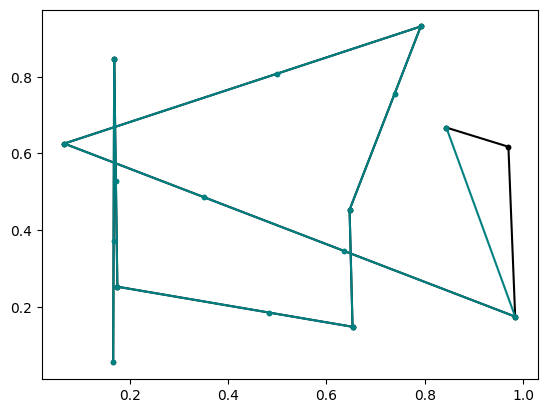

In [658]:
def normalize_vec(v):
    norm = np.linalg.norm(v)
    return v / norm


def parametrize_to_arr(path, ret_size=365):
    tot_dist = total_distance(path)
    all_dist = all_distances(path)
    step_size = tot_dist / ret_size

    def parametrize_line(p1, p2, ret_size):
        if ret_size == 0:
            return []

        direction = normalize_vec(p2 - p1)
        step = direction * step_size

        return [p1 + i * step for i in range(ret_size)]

    parametrized_arr = []
    for i, dist in enumerate(all_dist):
        n_points = round(dist / step_size)
        parametrized_arr += parametrize_line(path[i], path[i+1], n_points)

    return np.array(parametrized_arr + [path[-1]])


parametrized_path = parametrize_to_arr(path, 16)
fig, ax = plt.subplots(1)
draw_path(path, ax)
draw_path(parametrized_path, ax, 'teal')


# Infecting the population

- `infect_area(population, inf_center, n_to_infect)` indicates that `n_to_infects` closest points to `inf_center` in `population` are going to be infected
- `infect_path(population, path, r)` infects `population` along `path` where the number of infections starts at `r` (rounded to an integer) and grows exponentially


<Axes: >

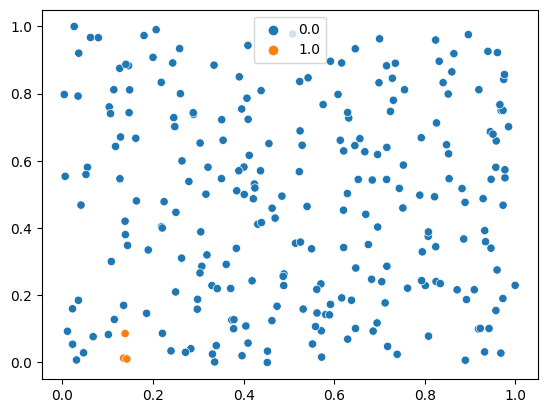

In [659]:
def infect_area(population, inf_center, n_to_infect):
    x, y = inf_center

    kd_population = KDTree(population[:, :2])
    to_infect_idx = kd_population.query([x, y], n_to_infect)[1]
    if type(to_infect_idx) == np.int64:
        to_infect_idx = [to_infect_idx]

    cp_pop = population.copy()
    for idx in to_infect_idx:
        if idx < cp_pop.shape[0]:
            cp_pop[idx] += np.array([0, 0, 1])

    return cp_pop


npop = infect_area(pop.to_numpy(), path[0], 3)
fig, ax = plt.subplots(1)
sns.scatterplot(x=npop[:, 0], y=npop[:, 1], hue=npop[:, 2])


In [660]:
def infect_path(population, path, r=1.1):
    iterable_pop = [infect_area(population, p, round(r ** (i + 1)))
                    for i, p in enumerate(path)]
    return iterable_pop


N = 4
npop = infect_path(pop.to_numpy(), parametrized_path)


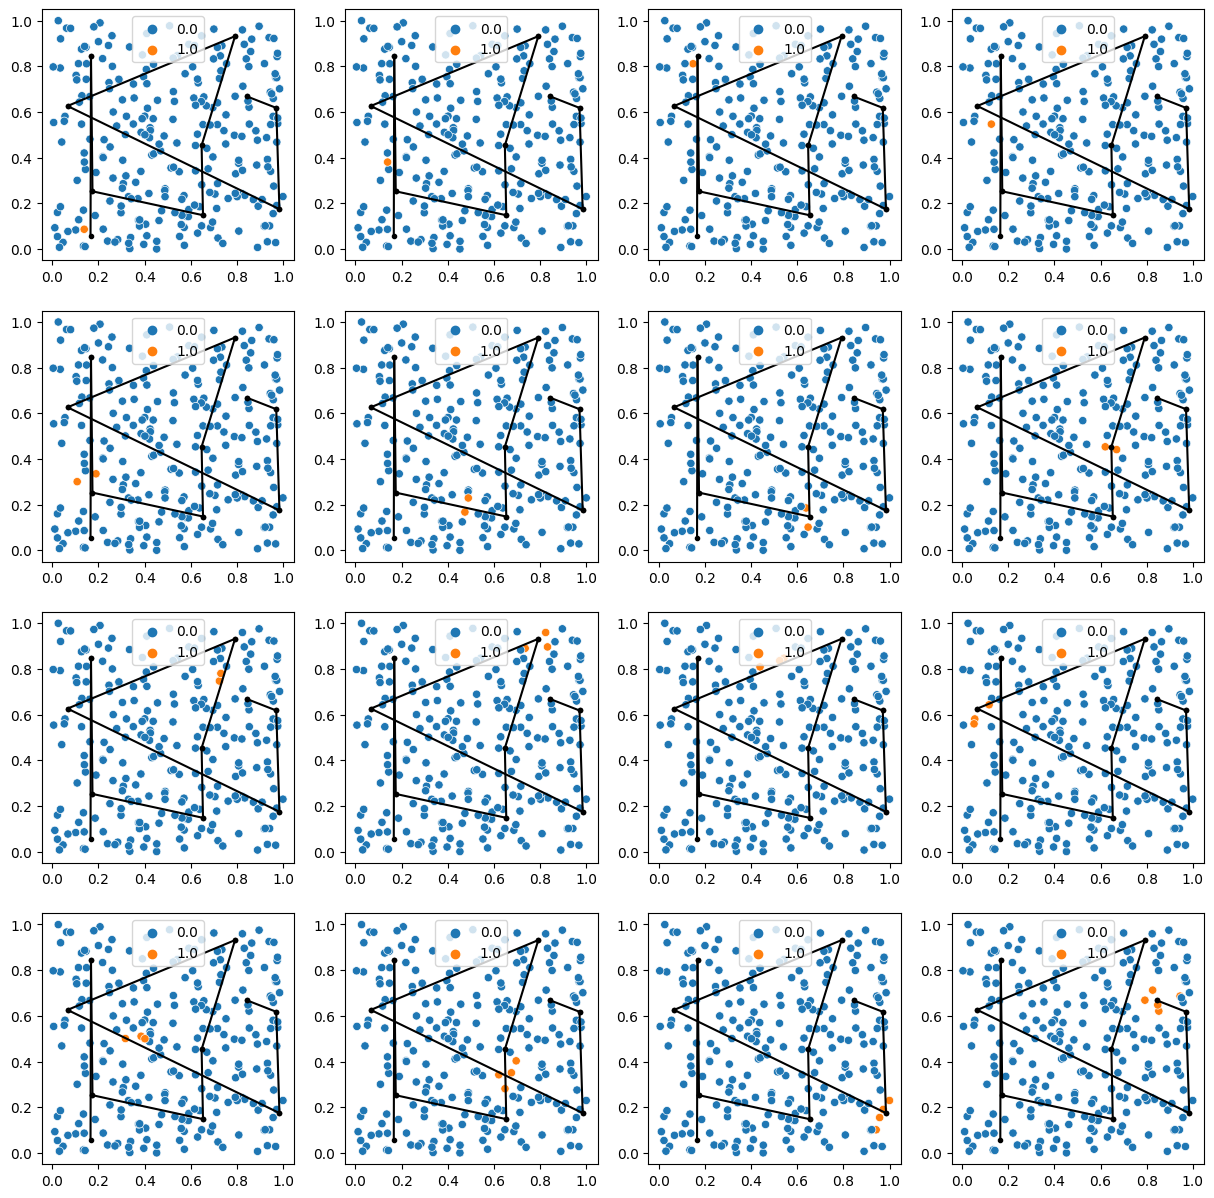

In [661]:
fig, ax = plt.subplots(N, N, figsize=(15, 15))
for i in range(N):
    for j in range(N):
        current_pop = npop[N * i + j]
        sns.scatterplot(
            x=current_pop[:, 0], y=current_pop[:, 1], hue=current_pop[:, 2], ax=ax[i, j])
        draw_path(path, ax=ax[i, j])


# Example use case

This may take a while


In [662]:
def convert_data_to_2d(data, file_path="infections.csv"):
    to_ret = []
    for i, day in enumerate(data):
        def engrave_day(data_point):
            x, y, state = data_point
            return np.array([x, y, state, i+1])
        new_day = list(map(engrave_day, day))
        to_ret += new_day
    return np.array(to_ret)


In [663]:
population = generate_population(500)
path = generate_path(5)
param_path = parametrize_to_arr(path, 100)
data = infect_path(population.to_numpy(), param_path)
transformed_data = convert_data_to_2d(data)


In [664]:
np.savetxt("infections.csv", transformed_data, delimiter=',')
np.savetxt("path.csv", param_path, delimiter=',')
